In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transaction-fruad/Train_without_Data_balancing.csv
/kaggle/input/transaction-fruad/Test_without_Data_balancing.csv
/kaggle/input/its-a-fraud/train.csv
/kaggle/input/its-a-fraud/test.csv
/kaggle/input/its-a-fraud/mock_submission.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
train=pd.read_csv("../input/transaction-fruad/Train_without_Data_balancing.csv")
train=train.drop(train.columns[0],axis=1)

In [5]:
from sklearn import metrics
from sklearn.metrics import classification_report

In [6]:
def Evalution(y_test,predictions): 
    score=metrics.accuracy_score(y_test, predictions)
    cm = metrics.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    print(classification_report(y_test, predictions))
def AUC(model,x_train,y_train,x_test,y_test,predictions_test,predictions_train):
    metrics.plot_roc_curve(model, x_train, y_train) 
    metrics.plot_roc_curve(model, x_test, y_test) 
    fpr1, tpr1, thresholds1=metrics.roc_curve(y_train,predictions_train)
    fpr, tpr, thresholds=metrics.roc_curve(y_test,predictions_test)
    # auc score
    print("AUC score for train: {}".format(metrics.auc(fpr1, tpr1)))
    print("AUC score for test: {}".format(metrics.auc(fpr, tpr)))
def Eval(model,X_over,y_over,x_test,y_test): 
    model.fit(X_over,y_over)
    predictions_test = model.predict(x_test)
    predictions_train = model.predict(X_over)
#     Evalution(y_over,predictions_train)
#     Evalution(y_test,predictions_test)
    AUC(model,X_over,y_over,x_test,y_test,predictions_test,predictions_train)


## StratifiedKfold Cross validation

In [7]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [8]:
def training(model,train,test,fold_no):
    x_train=train.drop(['isFraud'],axis=1)
    y_train=train.isFraud
    x_test=test.drop(['isFraud'],axis=1)
    y_test=test.isFraud
    Eval(model,x_train,y_train,x_test,y_test)
    score = model.score(x_test,y_test)
    print('For Fold {} the accuracy is {}'.format(str(fold_no),score))
    
def kFold(skf,model,train,x,y):
    fold_no=1
    for train_index,test_index in skf.split(x,y):
        train1 = train.iloc[train_index,:]
        test = train.iloc[test_index,:]
        training(model,train1, test, fold_no)
        fold_no += 1

In [9]:
x=train
y=train.isFraud

### decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier
pipe=Pipeline([('scaler',StandardScaler()),('Decision',DecisionTreeClassifier())])

AUC score for train: 0.998709469269237
AUC score for test: 0.7753940170440144
For Fold 1 the accuracy is 0.9662455831385963
AUC score for train: 0.9984660324525098
AUC score for test: 0.7653264491657841
For Fold 2 the accuracy is 0.9654214786466624
AUC score for train: 0.9985870197085187
AUC score for test: 0.7650037644287722
For Fold 3 the accuracy is 0.9653989004414039
AUC score for train: 0.998264247145401
AUC score for test: 0.7689724145452432
For Fold 4 the accuracy is 0.9645183504363238
AUC score for train: 0.9984673711381786
AUC score for test: 0.7806588692978745
For Fold 5 the accuracy is 0.9651731183888193


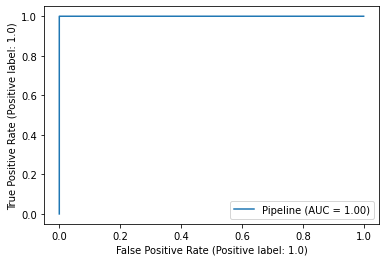

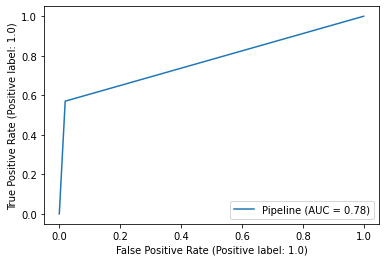

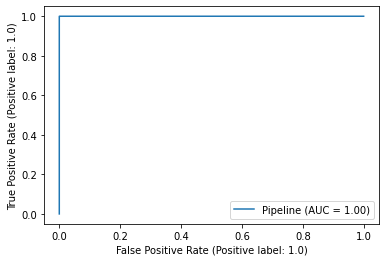

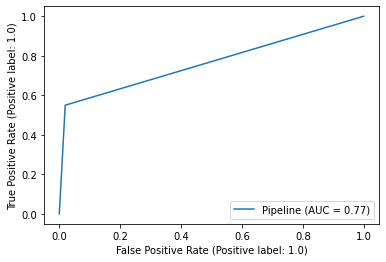

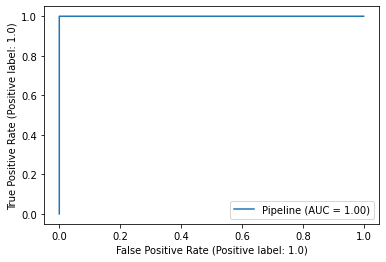

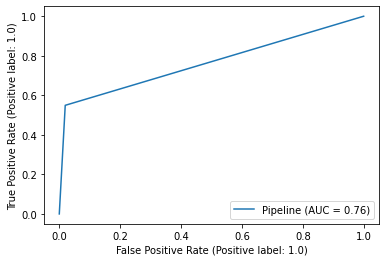

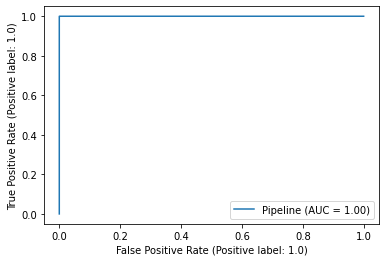

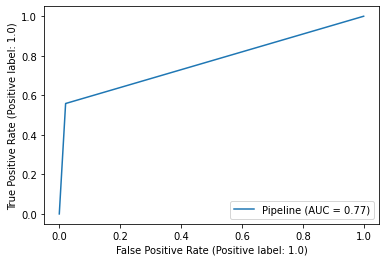

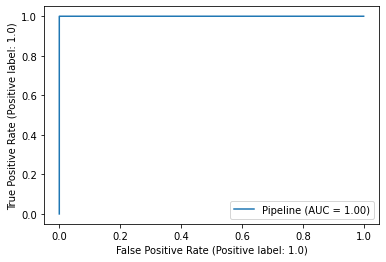

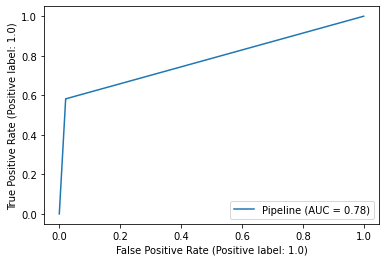

In [11]:
kFold(skf,pipe,train,x,y)

### output file

In [12]:
test=pd.read_csv("../input/transaction-fruad/Test_without_Data_balancing.csv")
test=test.drop(test.columns[0],axis=1)
predictions_test = pipe.predict(test)
Test_df_predictions=pd.DataFrame(data=predictions_test,columns=["isFraud"])
Test_df_predictions.reset_index(inplace=True)
Test_df_predictions.rename(columns={"index":"Id"},inplace=True)
Test_df_predictions.head()
Test_df_predictions.to_csv("./randomforest_predictions.csv",index=False)

### XGBoost

In [13]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=500,
        max_depth=12,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma = 0.2,
        alpha = 5,
        missing=-1,
        tree_method='gpu_hist')

AUC score for train: 0.8520753029376626
AUC score for test: 0.7802078393660113
For Fold 1 the accuracy is 0.9827389620799043
AUC score for train: 0.8541350108992347
AUC score for test: 0.7574200559152606
For Fold 2 the accuracy is 0.9813729806617671
AUC score for train: 0.8519747879475825
AUC score for test: 0.7720052101116581
For Fold 3 the accuracy is 0.9825131800273196
AUC score for train: 0.8548162325277077
AUC score for test: 0.7688735829241057
For Fold 4 the accuracy is 0.9820277486142627
AUC score for train: 0.852696166194042
AUC score for test: 0.7669380990531379
For Fold 5 the accuracy is 0.9818922793827118


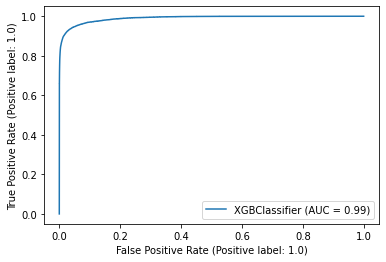

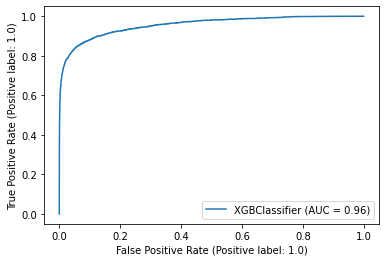

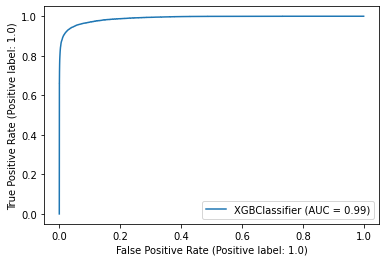

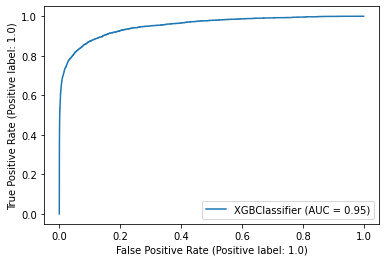

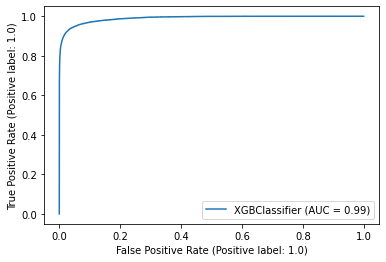

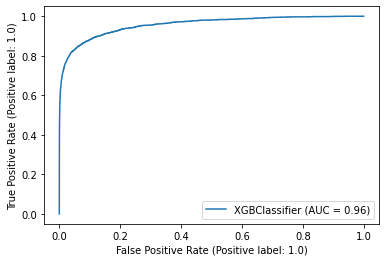

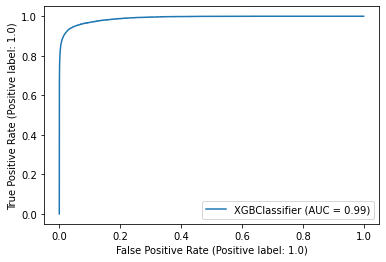

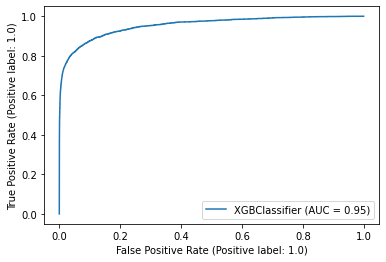

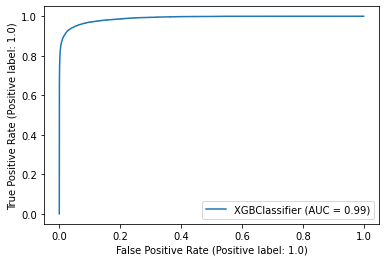

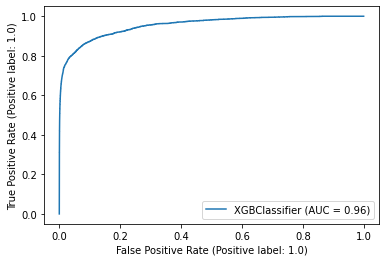

In [14]:
kFold(skf,model,train,x,y)

In [15]:
test=pd.read_csv("../input/transaction-fruad/Test_without_Data_balancing.csv")
test=test.drop(test.columns[0],axis=1)
predictions_test = model.predict(test)
Test_df_predictions=pd.DataFrame(data=predictions_test,columns=["isFraud"])
Test_df_predictions.reset_index(inplace=True)
Test_df_predictions.rename(columns={"index":"Id"},inplace=True)
Test_df_predictions.head()
Test_df_predictions.to_csv("./randomforest_predictions.csv",index=False)